In [ ]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 120 (delta 54), reused 99 (delta 38), pack-reused 0
Receiving objects: 100% (120/120), 98.64 KiB | 8.22 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
import sys
sys.path.append('glo-flow/')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 'glo-flow/']

In [ ]:
!pip install -q comet_ml

     |████████████████████████████████| 299 kB 15.6 MB/s 
     |████████████████████████████████| 52 kB 1.9 MB/s 
     |████████████████████████████████| 530 kB 63.2 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 


In [ ]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

BW_METHOD = 0.1
N_COMPONENTS = 128

### Training the model

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
from modules.glo import GLOGenerator, GLOModel, SampleGenerator
from modules.train import GLOTrainer, visualize_image_grid
from modules.dataset import IdxDataset
from modules.validate import Validator
from modules.loss import LapLoss

In [ ]:
cifar_train = CIFAR10(root='datasets', train=True, transform=transforms.ToTensor(), download=True)
cifar_test = CIFAR10(root='datasets', train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


In [ ]:
cifar_train = IdxDataset(cifar_train)
cifar_test = IdxDataset(cifar_test)

In [ ]:
train_loader = DataLoader(cifar_train, batch_size=16, shuffle=False)
val_loader = DataLoader(cifar_test, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
generator = GLOGenerator(min_channels=64,
                         max_channels=1024,
                         noise_channels=N_COMPONENTS,
                         num_blocks=4,
                         dataloader=train_loader).to(device)
sample_generator = SampleGenerator(train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator).to(device)

In [ ]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='glo-cifar',
                        workspace='alexandernevarko')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/glo-cifar/60458f570278404cb4c07602e0f0a266



In [ ]:
trainer = GLOTrainer(model, use_gpu=True, logger=experiment)

In [ ]:
zlr = 1e0
loss_func = LapLoss(max_levels=3, channels=3, device=device)
optimizer = torch.optim.SGD([
    {'params': model.generator.parameters(), 'lr': 1e-3},
    {'params': model.z, 'lr': zlr}
])

In [ ]:
torch.sum(model.z[0]**2)

tensor(0.9998, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
n_epochs = 25
trainer.train(n_epochs=n_epochs, train_loader=train_loader, 
              loss_func=loss_func, optimizer=optimizer, 
              exp_name=f'Big_LapL1_z_{N_COMPONENTS}_zlr_1e0_{n_epochs}+++_epochs_cifar10', model_path='')

Average epoch 0 loss: 0.06026451920866966


Average epoch 1 loss: 0.059431550526618956


Average epoch 2 loss: 0.05882217881679535


Average epoch 3 loss: 0.05838238895177841


Average epoch 4 loss: 0.058069616253376005


Average epoch 5 loss: 0.0578494078040123


Average epoch 6 loss: 0.05769386408090591


Average epoch 7 loss: 0.05758190509200096


Average epoch 8 loss: 0.057498704388141635


Average epoch 9 loss: 0.05743430000901222


Average epoch 10 loss: 0.05738241003632545


Average epoch 11 loss: 0.057339047943353656


Average epoch 12 loss: 0.05730157381653786


Average epoch 13 loss: 0.05726850964784622


Average epoch 14 loss: 0.05723869098782539


Average epoch 15 loss: 0.05721134502768516


Average epoch 16 loss: 0.05718603836417198


Average epoch 17 loss: 0.05716228308439255


Average epoch 18 loss: 0.057139912123680116


Average epoch 19 loss: 0.057118643292188645


Average epoch 20 loss: 0.05709840294957161


Average epoch 21 loss: 0.057078925292491915


Average epoch 22 loss: 0.05706024481058121


Average epoch 23 loss: 0.05704217114329338


Average epoch 24 loss: 0.05702469730377197


In [ ]:
# model.load_state_dict(torch.load('/content/m/z_32_zlr_1e2_50_epochs_model.pth'))

<All keys matched successfully>

In [ ]:
z = nn.Parameter(torch.randn(size=(len(val_loader.dataset), N_COMPONENTS), device=device, requires_grad=True))
optimizer = torch.optim.SGD([z], lr=5e1)
loss_func = LapLoss(max_levels=3, channels=3, device=device)

validator = Validator(model, val_loader, loss_func, optimizer)

In [ ]:
z_new, loss = validator.validate(z=z, min_loss=0.06, max_iter=60)

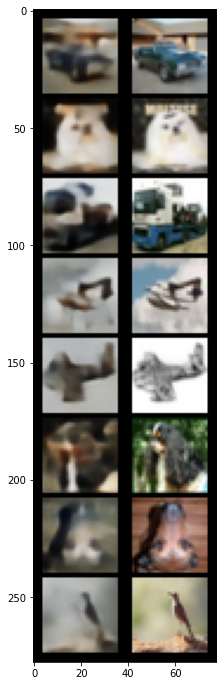

In [ ]:
idx = torch.randint(low=0, high=len(z), size=(8, ))
img = []
for i in idx:
    img.append(train_loader.dataset[i][1])
img = torch.cat(img).view(8, 3, 32, 32)
res = validator.visualize_val_results(z=model.z[idx], img=img)
plt.figure(figsize=(18, 12))
plt.imshow(res)

In [ ]:
img.shape

torch.Size([8, 1, 28, 28])

In [ ]:
!rm -rf glo-flow

In [ ]:
!cp Big_LapL1_z_128_zlr_1e0_25+++_epochs_cifar10_model.pth 

Now let's look at the model Z distribution!

In [ ]:
z_numpy = model.z.detach().cpu().numpy()

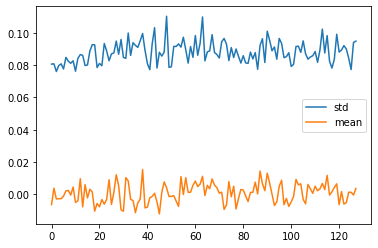

In [ ]:
plt.plot(z_numpy.std(axis=0), label='std')
plt.plot(z_numpy.mean(axis=0), label='mean')
plt.legend()

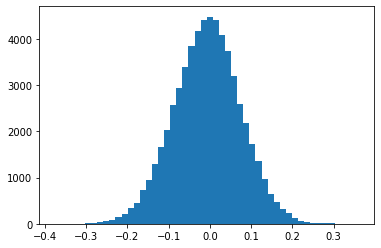

In [ ]:
_ = plt.hist(z_numpy[:, 0], bins=50)

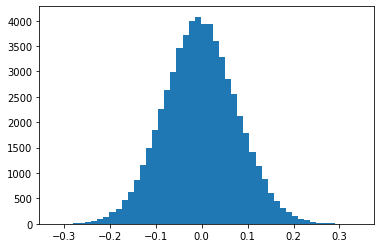

In [ ]:
_ = plt.hist(z_numpy[:, -10], bins=50)

In [ ]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([0, 3, 5])
torch.amax(torch.vstack([a, b]), dim=0)

tensor([1, 3, 5])

In [ ]:
a.long()

tensor([1, 2, 3])

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/glo-cifar/60458f570278404cb4c07602e0f0a266
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [25] : (0.05702469730377197, 0.06026451920866966)
COMET INFO:     Train loss [78125]            : (0.04043380916118622, 0.08204331994056702)
COMET INFO:     loss [9681]                   : (0.041250839829444885, 0.13823223114013672)
COMET INFO:   Others:
COMET INFO:     Name : Big_LapL1_z_128_zlr_1e0_25+++_epochs_cifar10
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 25
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages